In [64]:
import sys
import pandas as pd


sys.path.append('..')

In [65]:
import rbf_functions

In [76]:
rbf = rbf_functions.inverse_quadric_rbf.__name__
output_dir = f"../output/{rbf}/"

In [77]:
archives_by_nfe = pd.read_csv(output_dir + '10_hypervolume.csv')
archives_by_nfe.head()

,Unnamed: 0,Unnamed: 1,0,1,2,3,4,5
0,100,0,80.941635,0.816567,0.678278,0.813615,0.099990,1.0
1,100,1,79.451561,0.962812,0.728803,0.835786,0.094836,1.0
2,100,2,80.728876,0.988578,0.926677,0.967793,0.104433,1.0
3,100,3,77.021778,0.945903,0.855946,0.763639,0.098038,1.0
4,100,4,77.524306,0.964942,0.823775,0.903260,0.093020,1.0


we need to transform the dataframe back into platypus solution instances.

We need to have a collection of solutions for each generation


In [78]:
from platypus import Solution, Problem

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
for nfe, generation in archives_by_nfe.groupby("Unnamed: 0"):
    # we slice from 2, getting rid of the first two columns 
    # which contain the NFE and ID of each solution
    archive = []
    for i, row in generation.iloc[:, 2::].iterrows():
        solution = Solution(problem)
        solution.objectives = row
        archive.append(solution)
    archives[nfe] = archive
        


in this case our reference set is the final set of solutions (only a single seed). So let's load this data as well and turn it into a set of solution in the same way as we did with the archives.

In [79]:
data = pd.read_csv(output_dir + '10_solution.csv')

ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)


In [80]:
data

,hydropower,atomicpowerplant,baltimore,chester,environment,recreation
0,84.069113,0.982111,0.776192,0.869606,0.096067,1.0
1,84.248055,0.996883,0.574873,0.999747,0.096059,1.0
2,83.801966,0.997286,0.827114,0.999435,0.098676,1.0
3,84.035931,0.983242,0.701831,0.999711,0.108013,1.0
4,83.825119,0.999055,0.993275,0.999315,0.106419,1.0
5,82.875478,1.000000,0.998198,0.999999,0.099657,1.0


In [81]:
from platypus import Hypervolume

hv = Hypervolume(reference_set=ref_set)

nfes = []
hvs = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    hvs.append(hv.calculate(archive))

PlatypusError: objective with empty range

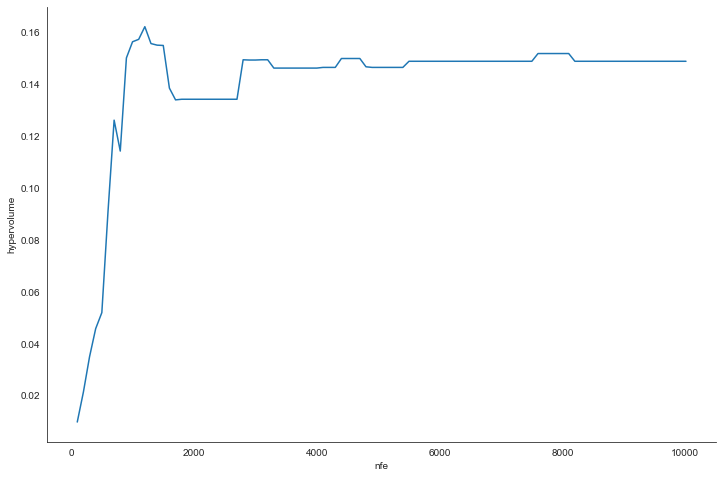

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, hvs)
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')

sns.despine()

plt.show()

In [83]:
e_progress = pd.read_csv(output_dir + '10_convergence.csv')
e_progress

,Unnamed: 0,nfe,improvements
0,0,100,20
1,1,200,24
2,2,300,26
3,3,400,27
4,4,500,30
...,...,...,...
410,410,19906,84
411,411,19930,84
412,412,19954,84
413,413,19978,84


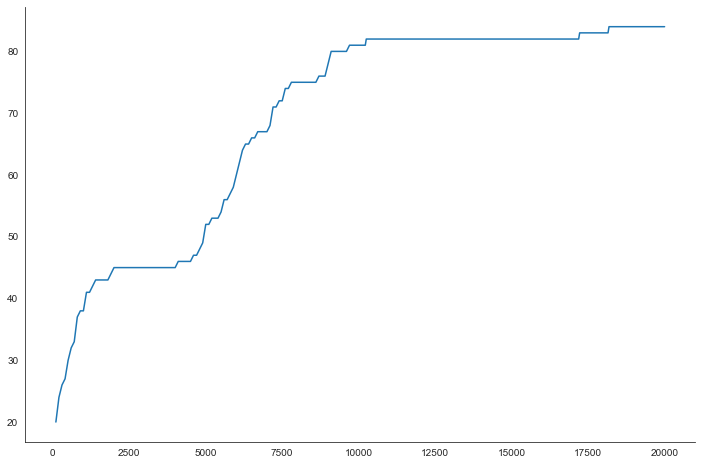

In [85]:
fig, ax = plt.subplots()
ax.plot(e_progress.nfe, e_progress.improvements)

sns.despine()

plt.show()